In [1]:
import polars as pl
import matplotlib.pyplot as plt

In [8]:
# df = pl.read_parquet("results/results-entsoe.parquet")
df = pl.read_parquet("results/results-etth2.parquet")

def epochs_to_convergence(losses: list[float]) -> int:
    threshold: float = 0.01
    for i in range(1, len(losses)):
        if abs(losses[i] - losses[i-1]) < threshold:
            return i
    return -1
final_df = df.with_columns(
    # final_train_loss=pl.col("loss_train").list.last(),
    # final_mse_test=pl.col("mses_test_mean").list.last(),
    # final_mae_test=pl.col("maes_test_mean").list.last(),
    # final_mape_test=pl.col("mapes_test_mean").list.last(),
    final_train_loss=pl.col("loss_train").list.min(),
    final_mse_test=pl.col("mses_test_mean").list.min(),
    final_mae_test=pl.col("maes_test_mean").list.min(),
    final_mape_test=pl.col("mapes_test_mean").list.min(),
    time_per_epoch=pl.col("duration") / pl.col("epochs"),
    epochs_to_convergence=pl.col("loss_train").map_elements(epochs_to_convergence),
).drop(["loss_train", "mses_test_mean", "maes_test_mean", "mapes_test_mean", "mses_test_variance", "maes_test_variance", "mapes_test_variance"])
final_df.write_excel("model-weights-final/results.xlsx")
final_df.with_columns(
    mse=pl.col("final_mse_test").round(3),
    mae=pl.col("final_mae_test").round(3),
    mape=pl.col("final_mape_test").round(3),
    duration=pl.col("duration").round(0),
    time_to_convergence=pl.col("time_per_epoch") * pl.col("epochs_to_convergence"),
).drop(["epochs", "batch_size", "learning_rate", "final_train_loss", "final_mse_test", "final_mae_test", "final_mape_test", "duration"])


model_type,dataset,input_length,output_length,loss_function,num_params,time_per_epoch,epochs_to_convergence,mse,mae,mape,time_to_convergence
str,str,i64,i64,str,i64,f64,i64,f64,f64,f64,f64
"""transformer""","""etth2""",12,24,"""mse""",3569,3.285423,2,0.237,0.383,2.148,6.570846
"""taylor-transfo…","""etth2""",12,24,"""mse""",10424,3.173988,3,0.121,0.25,1.508,9.521965
"""quadratic""","""etth2""",12,24,"""mse""",2494,2.339687,7,0.146,0.283,1.235,16.37781
"""cubic""","""etth2""",12,24,"""mse""",24648,1.601122,6,0.145,0.28,1.171,9.606734
"""linear""","""etth2""",12,24,"""mse""",2503,1.219857,4,0.145,0.28,1.437,4.879429
"""transformer""","""etth2""",12,24,"""mae""",3569,3.378924,2,0.241,0.382,1.993,6.757849
"""taylor-transfo…","""etth2""",12,24,"""mae""",10424,3.024879,3,0.124,0.247,1.458,9.074636
"""quadratic""","""etth2""",12,24,"""mae""",2494,2.283097,10,0.146,0.272,1.187,22.830972
"""quadratic-doub…","""etth2""",12,24,"""mae""",3154,3.004151,9,0.163,0.294,1.094,27.037359


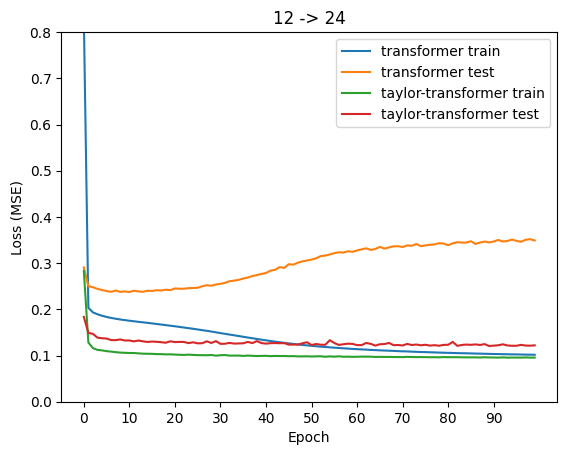

In [9]:
from examples.util import Dataset

input_size = 12
output_size = 24
loss_type = "mse"
dataset: Dataset = "etth2"


results_filtered = df.filter(
    (pl.col("input_length") == input_size) &\
    (pl.col("output_length") == output_size) &\
    (pl.col("loss_function") == loss_type) & \
    (pl.col("dataset") == dataset)
)


for model_type in [
    "transformer",
    "taylor-transformer",
    # "linear",
    # "quadratic",
    # "quadratic-double",
    # "cubic",
]:
    results_model = results_filtered.filter(pl.col("model_type") == model_type)
    loss_train = list(results_model[0][f"loss_train"])[0].to_numpy()
    loss_test = list(results_model[0][f"{loss_type}s_test_mean"])[0].to_numpy()
    plt.plot(loss_train, label=f"{model_type} train")
    plt.plot(loss_test, label=f"{model_type} test")


plt.xlabel("Epoch")
plt.ylabel(f"Loss ({loss_type.upper()})")
plt.ylim(0., 0.8)
plt.title(f"{input_size} -> {output_size}")
plt.xticks(range(0, 100, 10))
plt.legend()
plt.savefig(f"plots/transformers-etth2-{loss_type}-{input_size}-{output_size}.pdf", transparent=True)
plt.show()